In [35]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
data = pd.read_csv("Final_DF.csv")

In [37]:
data.head(10)

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,BTC_Price,ETH_Price,SOL_Price,XRP_Price
0,2020-04-10,99.519997,1662.50,0.05,0.729,41.67,6865.493164,158.412445,0.951054,0.187464
1,2020-04-11,99.519997,1662.50,0.05,0.729,41.67,6859.083008,158.216019,0.776819,0.188063
2,2020-04-12,99.519997,1662.50,0.05,0.729,41.67,6971.091797,161.142426,0.882507,0.190135
3,2020-04-13,99.349998,1662.50,0.05,0.770,41.17,6845.037598,156.279556,0.777832,0.187732
4,2020-04-14,98.889999,1715.85,0.05,0.750,37.76,6842.427734,157.596390,0.661925,0.185335
5,2020-04-15,99.459999,1712.25,0.05,0.635,40.84,6642.109863,153.286896,0.646651,0.181270
6,2020-04-16,100.029999,1717.85,0.05,0.617,40.11,7116.804199,172.157379,0.690816,0.190104
7,2020-04-17,99.779999,1693.15,0.05,0.642,38.15,7096.184570,171.638580,0.660728,0.190202
8,2020-04-18,99.779999,1693.15,0.05,0.642,38.15,7257.665039,186.914001,0.681096,0.194925
9,2020-04-19,99.779999,1693.15,0.05,0.642,38.15,7189.424805,181.614960,0.606969,0.190859


In [38]:
data = data.drop(['ETH_Price', 'SOL_Price', 'XRP_Price'], axis=1)

In [39]:
# convert columns datatypes into appropriate data types
data['Date'] = pd.to_datetime(data['Date'])

In [40]:
data.dtypes

Date             datetime64[ns]
Dollar_Index            float64
Gold_Price              float64
Interest_Rate           float64
US_10_Year              float64
VIX_Value               float64
BTC_Price               float64
dtype: object

In [41]:
# add the time index
data["time_idx"] = (data["Date"] - data["Date"].min()).dt.days

In [42]:
data.tail(10)

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,BTC_Price,time_idx
1726,2024-12-31,108.489998,2624.6030,4.33,4.572,17.35,93429.203125,1726
1727,2025-01-01,108.489998,2624.6030,4.33,4.572,17.35,94419.757812,1727
1728,2025-01-02,109.389999,2657.8921,4.33,4.561,17.93,96886.875000,1728
1729,2025-01-03,108.949997,2640.1664,4.33,4.601,16.13,98107.429688,1729
1730,2025-01-04,108.949997,2640.1664,4.33,4.601,16.13,98236.226562,1730
1731,2025-01-05,108.949997,2640.1664,4.33,4.601,16.13,98314.960938,1731
1732,2025-01-06,108.260002,2635.8796,4.33,4.623,16.04,102078.085938,1732
1733,2025-01-07,108.540001,2648.7119,4.33,4.684,17.82,96922.703125,1733
1734,2025-01-08,109.089996,2661.5352,4.33,4.692,17.70,95043.523438,1734
1735,2025-01-09,109.180000,2669.9489,4.33,4.688,18.07,92484.039062,1735


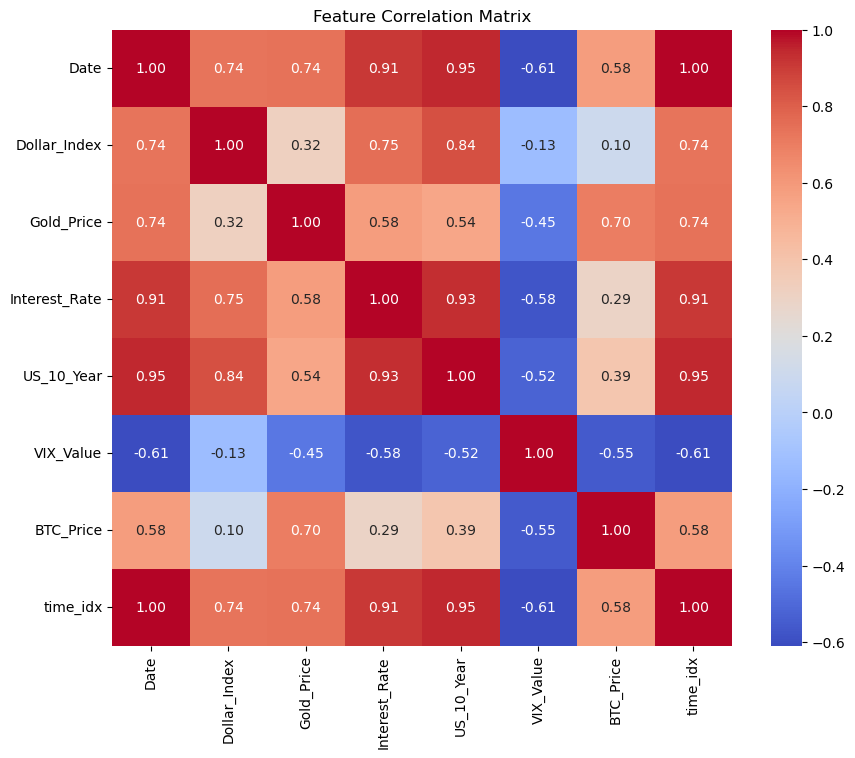

In [43]:
# Perform correlation analysis
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [44]:
# drop dollar index, interest rate
data = data.drop(['Dollar_Index', 'Interest_Rate'], axis=1)

In [45]:
data.head(10)

,Date,Gold_Price,US_10_Year,VIX_Value,BTC_Price,time_idx
0,2020-04-10,1662.50,0.729,41.67,6865.493164,0
1,2020-04-11,1662.50,0.729,41.67,6859.083008,1
2,2020-04-12,1662.50,0.729,41.67,6971.091797,2
3,2020-04-13,1662.50,0.770,41.17,6845.037598,3
4,2020-04-14,1715.85,0.750,37.76,6842.427734,4
5,2020-04-15,1712.25,0.635,40.84,6642.109863,5
6,2020-04-16,1717.85,0.617,40.11,7116.804199,6
7,2020-04-17,1693.15,0.642,38.15,7096.184570,7
8,2020-04-18,1693.15,0.642,38.15,7257.665039,8
9,2020-04-19,1693.15,0.642,38.15,7189.424805,9


In [46]:
# add additional features
data["month"] = data.Date.dt.month.astype(str).astype("category")  # categories have be strings
data["day_of_week"] = data.Date.dt.dayofweek.astype(str).astype("category")
data["day_of_year"] = data.Date.dt.dayofyear.astype(str).astype("category")
data["quarter"] = data.Date.dt.quarter.astype(str).astype("category")  # categories have be strings

data["log_price"] = np.log(data.BTC_Price + 1e-8)

In [47]:
data.head(10)

,Date,Gold_Price,US_10_Year,VIX_Value,BTC_Price,time_idx,month,day_of_week,day_of_year,quarter,log_price
0,2020-04-10,1662.50,0.729,41.67,6865.493164,0,4,4,101,2,8.834263
1,2020-04-11,1662.50,0.729,41.67,6859.083008,1,4,5,102,2,8.833329
2,2020-04-12,1662.50,0.729,41.67,6971.091797,2,4,6,103,2,8.849527
3,2020-04-13,1662.50,0.770,41.17,6845.037598,3,4,0,104,2,8.831279
4,2020-04-14,1715.85,0.750,37.76,6842.427734,4,4,1,105,2,8.830898
5,2020-04-15,1712.25,0.635,40.84,6642.109863,5,4,2,106,2,8.801185
6,2020-04-16,1717.85,0.617,40.11,7116.804199,6,4,3,107,2,8.870214
7,2020-04-17,1693.15,0.642,38.15,7096.184570,7,4,4,108,2,8.867313
8,2020-04-18,1693.15,0.642,38.15,7257.665039,8,4,5,109,2,8.889813
9,2020-04-19,1693.15,0.642,38.15,7189.424805,9,4,6,110,2,8.880366


In [48]:
data['currency_type']= 'BTC'

In [49]:
data['currency_type'] = data['currency_type'].astype(str).astype("category")

In [50]:
data.dtypes

Date             datetime64[ns]
Gold_Price              float64
US_10_Year              float64
VIX_Value               float64
BTC_Price               float64
time_idx                  int64
month                  category
day_of_week            category
day_of_year            category
quarter                category
log_price               float64
currency_type          category
dtype: object

In [51]:
# add the time index
data["time_idx"] = (data["Date"] - data["Date"].min()).dt.days

In [52]:
# Create lag features for BTC_Price
data['BTC_Price_Lag1'] = data['BTC_Price'].shift(1)
data['BTC_Price_Lag2'] = data['BTC_Price'].shift(2)
data['BTC_Price_Lag3'] = data['BTC_Price'].shift(3)
data = data.dropna()


In [53]:
# Scaling numerical features
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
numeric_features = ["BTC_Price", "Gold_Price", "US_10_Year", "VIX_Value", "BTC_Price_Lag1", "BTC_Price_Lag2", "BTC_Price_Lag3"]
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [54]:
data.head(10)

,Date,Gold_Price,US_10_Year,VIX_Value,BTC_Price,time_idx,month,day_of_week,day_of_year,quarter,log_price,currency_type,BTC_Price_Lag1,BTC_Price_Lag2,BTC_Price_Lag3
3,2020-04-13,0.030926,0.057615,0.873621,0.002040,3,4,0,104,2,8.831279,BTC,0.003306,0.002181,0.002245
4,2020-04-14,0.076948,0.053149,0.771982,0.002013,4,4,1,105,2,8.830898,BTC,0.002040,0.003306,0.002181
5,2020-04-15,0.073843,0.027468,0.863785,0.000000,5,4,2,106,2,8.801185,BTC,0.002013,0.002040,0.003306
6,2020-04-16,0.078673,0.023448,0.842027,0.004771,6,4,3,107,2,8.870214,BTC,0.000000,0.002013,0.002040
7,2020-04-17,0.057366,0.029031,0.783607,0.004564,7,4,4,108,2,8.867313,BTC,0.004771,0.000000,0.002013
8,2020-04-18,0.057366,0.029031,0.783607,0.006187,8,4,5,109,2,8.889813,BTC,0.004564,0.004771,0.000000
9,2020-04-19,0.057366,0.029031,0.783607,0.005501,9,4,6,110,2,8.880366,BTC,0.006187,0.004564,0.004771
10,2020-04-20,0.050292,0.023225,0.952906,0.002411,10,4,0,111,2,8.836659,BTC,0.005501,0.006187,0.004564
11,2020-04-21,0.044815,0.012059,1.000000,0.002394,11,4,1,112,2,8.836421,BTC,0.002411,0.005501,0.006187
12,2020-04-22,0.065561,0.023671,0.897765,0.004775,12,4,2,113,2,8.870271,BTC,0.002394,0.002411,0.005501


In [55]:
# create the TimeSeriesDataset
max_prediction_length = 30
max_encoder_length = 90
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="BTC_Price",
    group_ids=["currency_type"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["currency_type"],
    static_reals=[],
    time_varying_known_categoricals=["month", "day_of_week", "day_of_year", "quarter"],
    time_varying_known_reals=["Gold_Price", "US_10_Year", "VIX_Value"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["BTC_Price","log_price", "BTC_Price_Lag1", "BTC_Price_Lag2", "BTC_Price_Lag3"],
    target_normalizer=GroupNormalizer(
        groups=["currency_type"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [56]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    # optimizer="Ranger",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimize

Number of parameters in network: 14.3k


c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottlenec

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.007079457843841384
Restoring states from the checkpoint path at c:\Users\Sathmika\Desktop\FYP\cryptoCurrencyPricePredictionTFT\cryptoCurrencyPricePredictionTFT\final\.lr_find_856d6de9-b922-4ba2-bbb1-8d5b2ccbc3d6.ckpt
Restored all states from the checkpoint at c:\Users\Sathmika\Desktop\FYP\cryptoCurrencyPricePredictionTFT\cryptoCurrencyPricePredictionTFT\final\.lr_find_856d6de9-b922-4ba2-bbb1-8d5b2ccbc3d6.ckpt


suggested learning rate: 0.007079457843841384


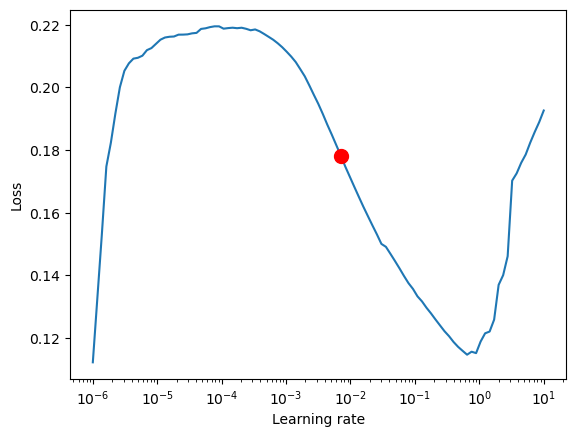

C:\Users\Sathmika\AppData\Local\Temp\ipykernel_10952\4268711780.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [57]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [58]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=64,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.003,
    hidden_size=32,
    attention_head_size=8,
    dropout=0.2,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    # optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 83.6k


c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minim

In [59]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 11.8 K | train
3  | prescalers                         | ModuleDict                      | 192    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 11.0 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.1 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [60]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [61]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


tensor(0.0513, device='cuda:0')

In [62]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


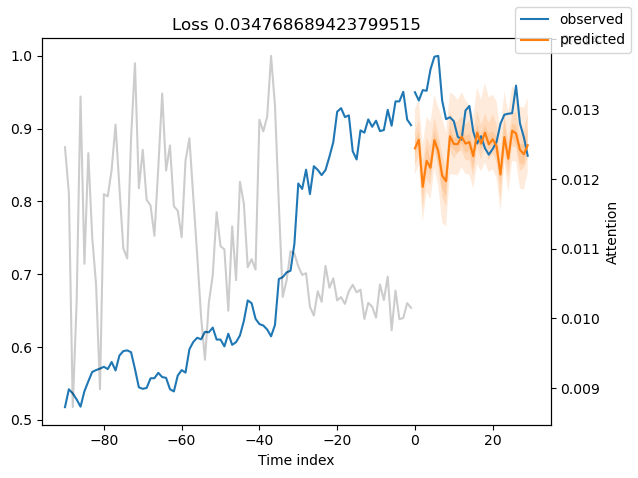

In [63]:
# Access the predictions from the named tuple
predictions_tensor = raw_predictions.output.prediction

# Get the number of available predictions (first dimension of the tensor)
num_predictions = predictions_tensor.size(0)

# Adjust loop to avoid out-of-bounds error
for idx in range(min(10, num_predictions)):  # Only iterate over available predictions
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [64]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation MAE: 0.051253437995910645


In [65]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


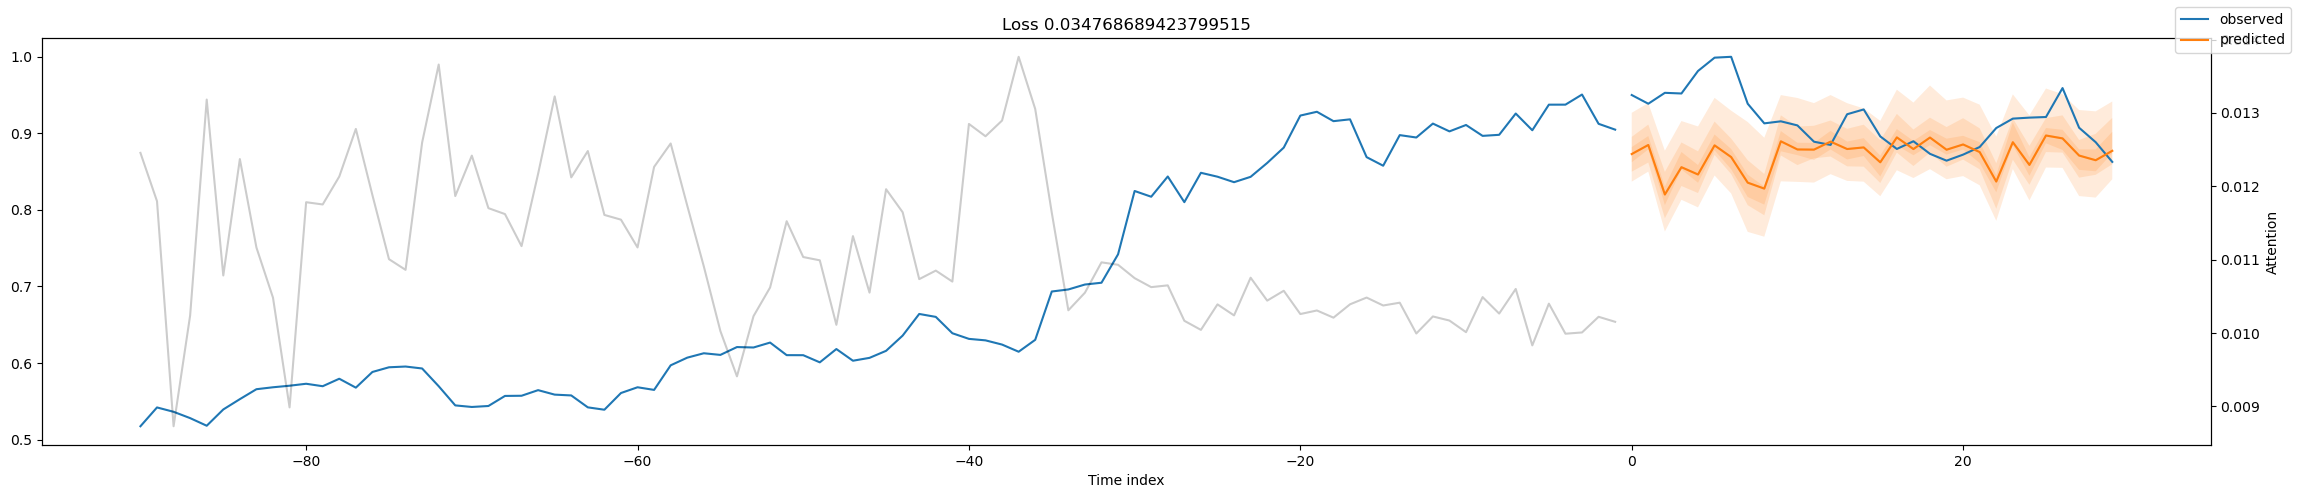

In [66]:
# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)